In [1]:
import os
os.chdir('..')

In [2]:
from src.experiment import CLIPGraphRun
from src.models.explainer import CLIPGraphExplainer, ArtGraphCaptumExplainer, GraphIntegratedGradients
from src.data import DataDict
from src.utils import load_ruamel
from src.visualization.clip_vis import get_img_path, get_style_by_case_id
from src.visualization.utils import SessionStateKey
from torch_geometric.explain import ThresholdConfig
import torch
import pandas as pd
import json

In [3]:
def get_prediction(run: CLIPGraphRun, case_id: int) -> torch.Tensor:
    class_feats = run.model.encode_graph(
        run.graph.x_dict, run.graph.edge_index_dict, normalize=True
    )
    img_tensor = (
        run.test_loader.dataset[case_id].get(DataDict.IMAGE).unsqueeze(0).to(run.device)
    )
    img_feats = run.model.encode_image(img_tensor, normalize=True)
    prediction = img_feats @ class_feats.T
    return  {
        SessionStateKey.LOGITS: prediction,
        SessionStateKey.IMG_FEATS: img_feats,
        SessionStateKey.GRAPH_FEATS: class_feats,
    }

In [4]:
def get_mappings(root: str, mapping_file: str) -> dict[dict[int, str]]:
    files = {k.split('_')[0]: pd.read_csv(f"{root}/{k}", names=["idx", "name"]).to_dict()["name"] for k in os.listdir(root)}
    with open(mapping_file) as f:
        artwork_mapping = json.load(f)
    artwork_mapping = {int(k): v for k, v in artwork_mapping.items()}
    files["artwork"] = {artwork_mapping[k]: v for k, v in files["artwork"].items() if k in artwork_mapping.keys()}
    return files

In [5]:
parameters = load_ruamel('./configs_cineca/proposed_model/0_1/sage/normal_clip_graph_sage2.yaml')
parameters["clean_out_dir"] = False
run = CLIPGraphRun(parameters=parameters)

Loading general parameters...
Done!
Loading dataloaders...
Done!
Loading model...
Done!
Loading metrics...
Done!
Loading tokenizer...
Done!
Loading criterion...
Done!
Loading optimizer...
Done!
Loading scheduler...
Done!
Loading early stop callback...
Done!


In [6]:
class2idx, idx2class = run.get_class_maps()

In [18]:
explainer = CLIPGraphExplainer(
    device=run.device,
    image_preprocess="clip",
    mappings=get_mappings(
        root="./data/external/artgraph2bestemotions/mapping/",
        mapping_file="./data/processed/graph/0_1/artwork_mapping.json",
    ),
)

## CHOOSE THE TEST INSTANCE

In [34]:
from ipywidgets import IntSlider

test_instance = IntSlider(
    value=0,
    min=0,
    max=len(run.test_loader.dataset)-1,
    step=1,
    description="Choose the test instance",
    orientation="horizontal",
)
display(test_instance)

IntSlider(value=0, description='Choose the test instance', max=11646)

In [101]:
test_instance.value = 1406

In [102]:
image_style = get_style_by_case_id(run=run, case_id=test_instance.value)
image_style

'neo-expressionism'

In [103]:
img_pth = get_img_path(run=run, case_id=test_instance.value)
img_pth

'data/raw/images-resized/pierre-alechinsky_port-b-bord-1986.jpg'

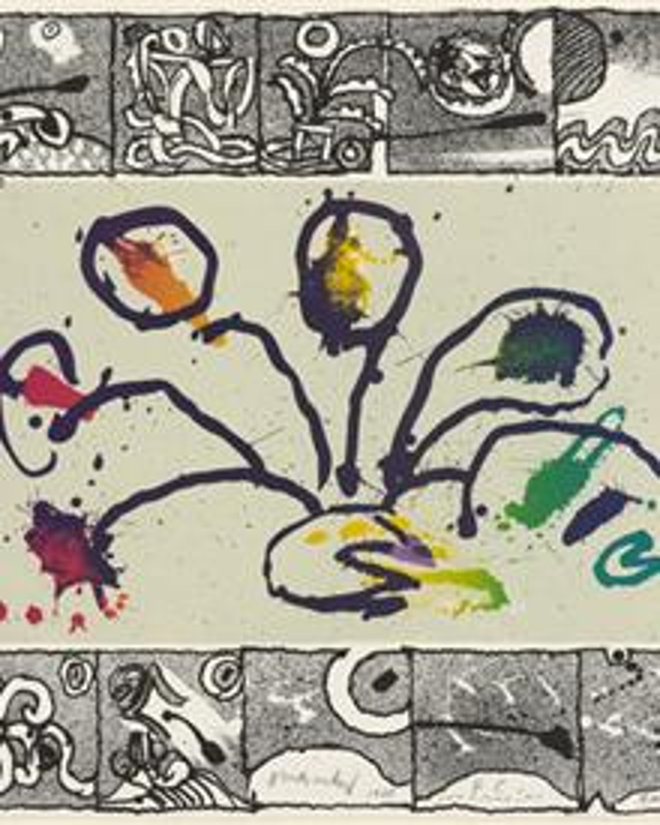

In [104]:
from PIL import Image
img = Image.open(img_pth).convert("RGB")
img.resize((img.width*3, img.height*3))

### EXPLAIN THE IMAGE

In [105]:
out = get_prediction(run=run, case_id=test_instance.value)
pred_idx = out[SessionStateKey.LOGITS].argmax().cpu().item()
pred_class = idx2class[pred_idx]
overlayed_image = explainer.explain_image(
            img_path=img_pth,
            model=run.model,
            reference_feats=out[SessionStateKey.GRAPH_FEATS],
            target=pred_idx,
            overlayed=True,
        )

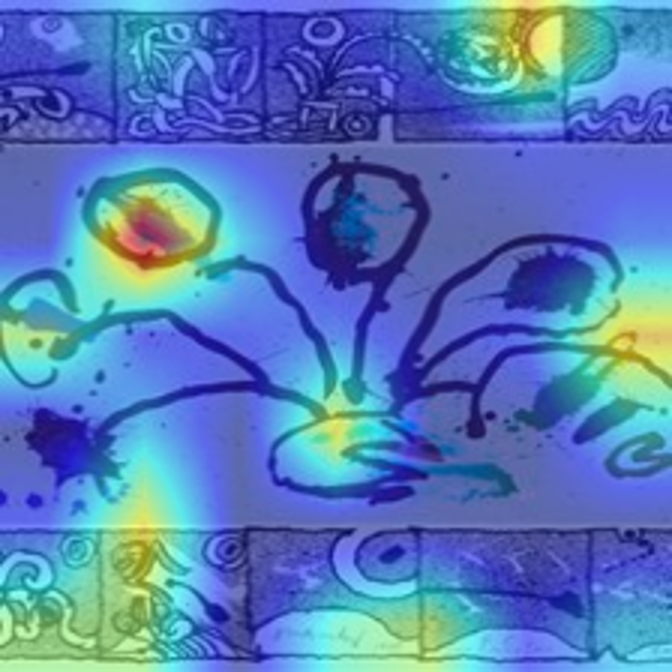

In [107]:
ov = Image.fromarray(overlayed_image, "RGB")
ov.resize((ov.width*3, ov.height*3))

In [108]:
f"Explaination of the image for class {pred_class}"

'Explaination of the image for class neo-expressionism'

### EXPLAIN THE GRAPH

In [109]:
explanation = explainer.explain_graph(
    model=run.model,
    graph=run.graph,
    reference_feats=out[SessionStateKey.IMG_FEATS].detach(),
    target_node=class2idx[pred_class],
    algo=ArtGraphCaptumExplainer(GraphIntegratedGradients, graph=run.graph),
    algo_kwargs=dict(
        explanation_type="model",
        node_mask_type="attributes",
        edge_mask_type="object",
        model_config=dict(
            mode="multiclass_classification",
            task_level="node",
            return_type="raw",
        ),
        threshold_config=ThresholdConfig(threshold_type="topk", value=100),
    ),
)
explainer.plot_explanation(explanation, run.graph.metadata(), run.graph)


GraphWidget(layout=Layout(height='800px', width='100%'))

In [74]:
from tqdm import tqdm
correct_case_ids = set()
for case_id in tqdm(range(len(run.test_loader.dataset))):
    image_style = get_style_by_case_id(run=run, case_id=case_id)
    out = get_prediction(run=run, case_id=case_id)
    pred_idx = out[SessionStateKey.LOGITS].argmax().cpu().item()
    pred_class = idx2class[pred_idx]
    if image_style == pred_class:
        print(f"{image_style} è uguale a {pred_class} per l'immagine {case_id}")
        correct_case_ids.add(case_id)

    

  0%|          | 0/11647 [00:00<?, ?it/s]/home/raffaele/art/contrastive-artwork-classification/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  1%|          | 103/11647 [00:03<05:56, 32.40it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 97


  2%|▏         | 175/11647 [00:05<05:50, 32.72it/s]

surrealism è uguale a surrealism per l'immagine 168


  2%|▏         | 255/11647 [00:07<05:53, 32.22it/s]

rococo è uguale a rococo per l'immagine 250


  3%|▎         | 303/11647 [00:09<05:48, 32.55it/s]

contemporary realism è uguale a contemporary realism per l'immagine 298


  4%|▍         | 516/11647 [00:16<05:49, 31.81it/s]

art deco è uguale a art deco per l'immagine 510


  5%|▌         | 599/11647 [00:19<06:56, 26.50it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 592
mannerism (late renaissance) è uguale a mannerism (late renaissance) per l'immagine 593
naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 598


  5%|▌         | 635/11647 [00:20<05:42, 32.20it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 631


  6%|▌         | 691/11647 [00:22<05:44, 31.81it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 685


  6%|▋         | 739/11647 [00:23<05:39, 32.14it/s]

impressionism è uguale a impressionism per l'immagine 733


  7%|▋         | 807/11647 [00:26<05:36, 32.18it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 802


  8%|▊         | 935/11647 [00:30<05:32, 32.20it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 930


  8%|▊         | 979/11647 [00:31<05:31, 32.17it/s]

ukiyo-e è uguale a ukiyo-e per l'immagine 974


  9%|▊         | 991/11647 [00:31<05:35, 31.72it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 985


  9%|▉         | 1023/11647 [00:32<05:38, 31.38it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 1017


 11%|█         | 1263/11647 [00:40<05:27, 31.67it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 1259


 12%|█▏        | 1411/11647 [00:44<05:21, 31.84it/s]

neo-expressionism è uguale a neo-expressionism per l'immagine 1406


 12%|█▏        | 1442/11647 [00:46<06:46, 25.13it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 1436


 12%|█▏        | 1450/11647 [00:46<05:56, 28.59it/s]

naïve art (primitivism) è uguale a naïve art (primitivism) per l'immagine 1446
ukiyo-e è uguale a ukiyo-e per l'immagine 1447


 13%|█▎        | 1510/11647 [00:48<05:17, 31.95it/s]

symbolism è uguale a symbolism per l'immagine 1503


 14%|█▍        | 1608/11647 [00:51<05:23, 31.07it/s]


KeyboardInterrupt: 

In [100]:
correct_case_ids

{97,
 168,
 250,
 298,
 510,
 592,
 593,
 598,
 631,
 685,
 733,
 802,
 930,
 974,
 985,
 1017,
 1259,
 1406,
 1436,
 1446,
 1447,
 1503}

In [47]:
import random
random.choice(list(correct_case_ids))

4852